### Subtractive Cancellation

__MATH 420__<br>
_Spring 2021_ <br>

Herbie is an online tool (https://herbie.uwplse.org/demo/) that attempts to modify a formula into a formula that is algebraically equivalent to the input, but evaluates more accurately using floating point numbers. Herbie gives its recommendations in a variety of languages, including Julia.

To test Herbie, let's try the expression $(1-\exp(x))/x$. We will specify that $x$ is a binary64 number that is between the least and greatest binary64.

When $x \approx 0$ we have $1 - \exp(x) \approx 1 - 1$.  So we expect subtractive cancellation when $x$ is near zero. Actually, we have
$$
   \lim_{x \to 0} \frac{1 - \exp(x)}{x} = -1.
$$
So when we test this code for $x \approx 0$, the result should be close to $-1$. 

Here is what Herbie recommends:

In [2]:
function herbie(x::Float64)
	return Float64(expm1(x) / Float64(-x))
end

herbie (generic function with 1 method)

In [3]:
function nonherbie(x::Float64)
    (1-exp(x))/x
end

nonherbie (generic function with 1 method)

In [4]:
using Gadfly

In [5]:
(a,b) = (-1.e-7, 1.0e-7);

In [6]:
p1 = layer(herbie,color=[colorant"red"],a,b);

In [7]:
p2 = layer(nonherbie,color=[colorant"white"],a,b);

For $x$ near zero, here is a graphical comparison:

In [9]:
plot(p1,p2, Guide.ylabel("Herbie & nonHerbie"), Guide.xlabel("x"))

The non Herbie code has _spurious_ oscillations for $x$ near zero, but the Herbie code looks like a line. The wild oscillations are rubbish, making Herbie's suggestion far more accurate near zero.

Away from zero, the two functions agree to a high degree.

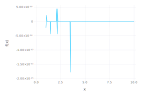

In [11]:
plot([x -> herbie(x) - nonherbie(x)], 1,10)

In [12]:
function payment(P::Number, r::Number, n::Integer)
    P*r*(1+r)^n/((1+r)^n-1)
end

payment (generic function with 1 method)

Let's use the `expm1` function to rewrite the denominator

In [14]:
function payment2(P::Number, r::Number, n::Integer)
    w = expm1(n*log(1+r))    
    P*r*(w+1)/w
end

payment2 (generic function with 1 method)

Does the fancy `expm1` function ever make a difference? Using `Float32` numbers and choosing $P = 10^6, r = 0.001$ and $n = 2$, we have

In [16]:
P = 1.0f9;

In [17]:
r = 0.0001f0;

In [18]:
n = 2

2

In [19]:
p1 = payment(P,r,n)

5.0001702f8

In [20]:
p2 = payment2(P,r,n)

4.99992f8

In [21]:
p1-p2

25024.0f0

Switching to `Float64` numbers, the difference is essentially zero:

In [23]:
P = convert(Float64,P)

1.0e9

In [24]:
r = convert(Float64,r)

9.999999747378752e-5

In [25]:
p1 = payment(P,r,n)

5.0007500124804187e8

In [26]:
p2 = payment2(P,r,n)

5.000750012480428e8

In [27]:
p1-p2

-9.5367431640625e-7